In [39]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

## 1. Niño 3.4 index

### 1.1 Compute monthly climatology for SST from Niño 3.4 region

In [40]:
da = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc",engine="netcdf4")
weights = np.cos(np.deg2rad(da.lat))
sst_weighted = da.sst.sel(lat=slice(-5,5),lon=slice(210,240)).weighted(weights)
region_mean = sst_weighted.mean(dim=('lon','lat'))
monthly_sst = region_mean.groupby('time.month').mean()
monthly_sst

<xarray.DataArray 'sst' (month: 12)>
array([26.024014, 26.362394, 27.003092, 27.491852, 27.456303, 27.141228,
       26.58982 , 26.112291, 25.98521 , 25.974686, 25.978508, 25.953588],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### 1.1 Subtract climatology from SST time series to obtain anomalies

In [42]:
x = region_mean.size
anoma = np.zeros(x-2)
for i in range(0,x-2):
    k = i % 12
    anoma[i] = region_mean[i] - monthly_sst[k]
    
print(anoma)

[-3.30963135e-01 -4.54664230e-01 -2.80950546e-01 -2.05434799e-01
 -2.30035782e-01 -3.66180420e-01 -6.16817474e-02  1.39263153e-01
 -1.82481766e-01 -5.41425705e-01 -5.23983002e-01 -3.64625931e-01
 -3.14182281e-01 -2.28069305e-01 -2.70000458e-01 -7.27558136e-02
  1.59219742e-01  2.20666885e-01 -1.81058884e-01 -5.52108765e-01
 -1.00966263e+00 -9.02921677e-01 -6.00603104e-01 -4.50906754e-01
 -3.74057770e-01 -3.43709946e-01 -4.38940048e-01 -5.22491455e-01
 -6.29348755e-01 -4.49424744e-01 -2.49549866e-01 -2.83357620e-01
 -7.10056305e-01 -6.79294586e-01 -8.98977280e-01 -9.90926743e-01
 -7.22728729e-01 -3.17501068e-01  1.08222961e-01  3.90274048e-01
  8.86363983e-02  3.47993851e-01  8.60031128e-01  8.39574814e-01
  6.82573318e-01  8.26736450e-01  9.65261459e-01  1.19773102e+00
  8.20079803e-01  4.90779877e-01 -1.26127243e-01 -8.39115143e-01
 -1.07551765e+00 -1.11114883e+00 -6.98534012e-01 -1.13474846e+00
 -1.10546494e+00 -1.05469704e+00 -1.17579079e+00 -1.19849396e+00
 -7.82169342e-01 -3.96112

### 1.2 Visualize the computed Niño 3.4. 

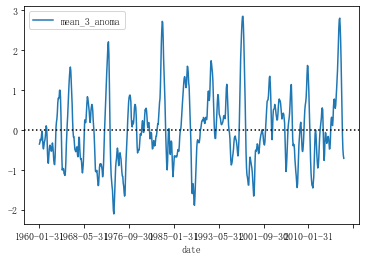

In [44]:
alist = ['JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','OND','NDJ','DJF']
templist=[]
for i in range(0,68):
    for j in range(0,10):
        templist.append(alist[j])
templist.append('JFM')
templist.append('FMA')

def moving_average(x,w): # consecutive 3-month running mean SST anomalies exceed the threshold.
    return np.convolve(x, np.ones(w),'valid') / w
mean_anoma = moving_average(anoma,3) 

df = pd.DataFrame(mean_anoma,columns=['mean_3_anoma'])
df['mo'] = pd.DataFrame(templist)

def get_date_list(begin_date,end_date):
    date_list = [x.strftime('%Y-%m-%d') for x in list(pd.date_range(start=begin_date,end=end_date,freq='M'))]
    return date_list

date = get_date_list('1960-01-15','2016-12-15')
df['date'] = pd.DataFrame(date)

# Visualize the computed Niño 3.4.
df.plot(x="date",y="mean_3_anoma")
#plt.axhline(y=0.5,ls="-",c="red")
plt.axhline(y=0,ls=":",c="black")
#plt.axhline(y=-0.5,ls="-",c="blue")

## 2. Earth’s energy budget

### 2.1 Make a 2D plot of the time-mean TOA longwave, shortwave, and solar radiation for all-sky conditions. Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux.

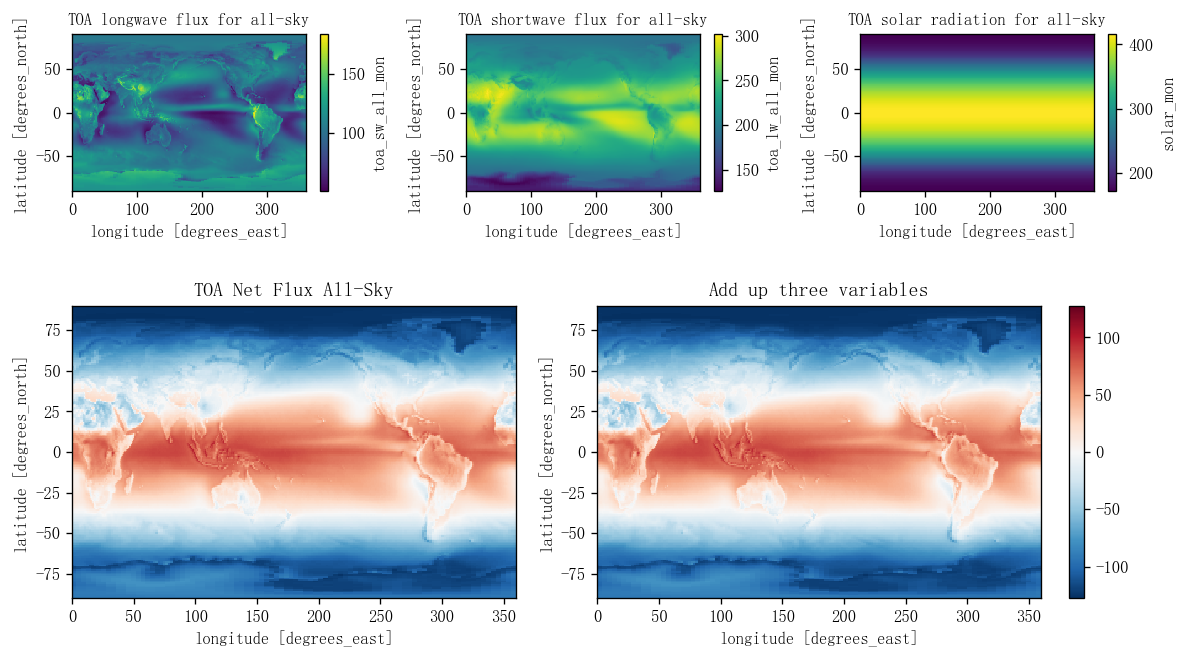

In [45]:
d = xr.open_dataset('CERES_EBAF-TOA_200003-201701.nc',engine='netcdf4')

fig = plt.figure(figsize=(10,6), dpi=120)
grid = plt.GridSpec(5, 9)  

plt.subplot(grid[0:2, 0:3])
ax1 = d.toa_sw_all_mon.mean(dim='time').plot()
plt.title('TOA longwave flux for all-sky',fontsize=10)

plt.subplot(grid[0:2, 3:6])
ax2 = d.toa_lw_all_mon.mean(dim='time').plot()
plt.title('TOA shortwave flux for all-sky',fontsize=10)

plt.subplot(grid[0:2, 6:9])
ax3 = d.solar_mon.mean(dim='time').plot()
plt.title('TOA solar radiation for all-sky',fontsize=10)

plt.subplot(grid[2:5, 0:5])
ax4 = d.toa_net_all_mon.mean(dim='time').plot()
plt.title('TOA Net Flux All-Sky')

plt.subplot(grid[2:5, 4:10])
ax5 = (d.solar_mon.mean(dim='time') - d.toa_sw_all_mon.mean(dim='time') - d.toa_lw_all_mon.mean(dim='time') ).plot()
plt.title('Add up three variables')

plt.tight_layout()

### 2.2 Calculate and verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with the cartoon above.

In [48]:
temp=[]
x = d.solar_mon.mean(dim='time') - d.toa_sw_all_mon.mean(dim='time') - d.toa_lw_all_mon.mean(dim='time')
y = d.toa_net_all_mon.mean(dim='time')
(x-y).sum()

<xarray.DataArray ()>
array(1.6990367, dtype=float32)

### 2.3 Calculate and plot the total amount of net radiation in each 1-degree latitude band

Text(0, 0.5, 'total amount of net radiation/ W')

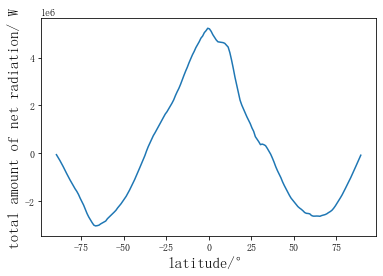

In [49]:
weights = np.cos(np.deg2rad(d.lat))
net_weighted = d.toa_net_all_mon.weighted(weights)
region_mean = net_weighted.sum(dim=['lon','time']).plot()
plt.xlabel('latitude/°',fontsize=15)
plt.ylabel('total amount of net radiation/ W',fontsize=15)

### 2.4 Calculate and plot composites of time-mean outgoing shortwave and longwave radiation for low and high cloud area regions

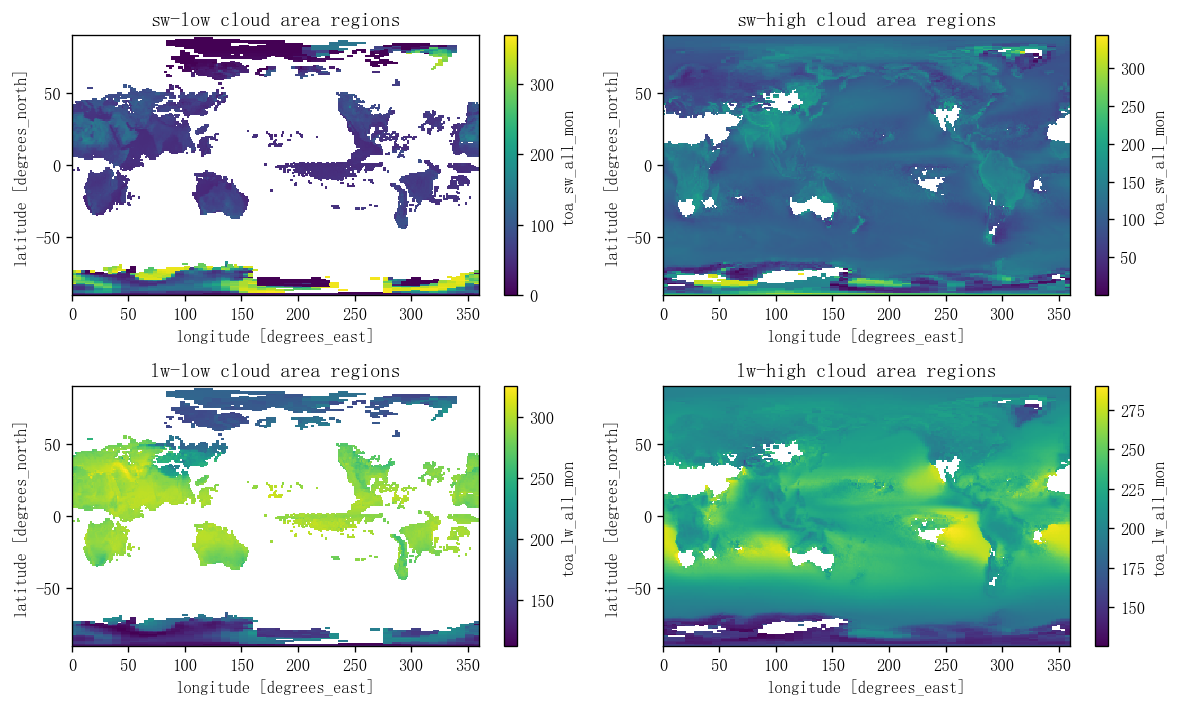

In [50]:
fig = plt.figure(figsize=(10,6), dpi=120)
grid = plt.GridSpec(4, 4)  
plt.subplot(grid[0:2, 0:2])
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon<=25)).mean(dim='time').plot()
plt.title('sw-low cloud area regions')
plt.subplot(grid[0:2, 2:4])
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon>=75)).mean(dim='time').plot()
plt.title('sw-high cloud area regions')
plt.subplot(grid[2:4, 0:2])
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon<=25)).mean(dim='time').plot()
plt.title('lw-low cloud area regions')
plt.subplot(grid[2:4, 2:4])
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon>=75)).mean(dim='time').plot()
plt.title('lw-high cloud area regions')

plt.tight_layout()

### 2.5 Calculate the global mean values of shortwave and longwave radiation, composited in high and low cloud regions

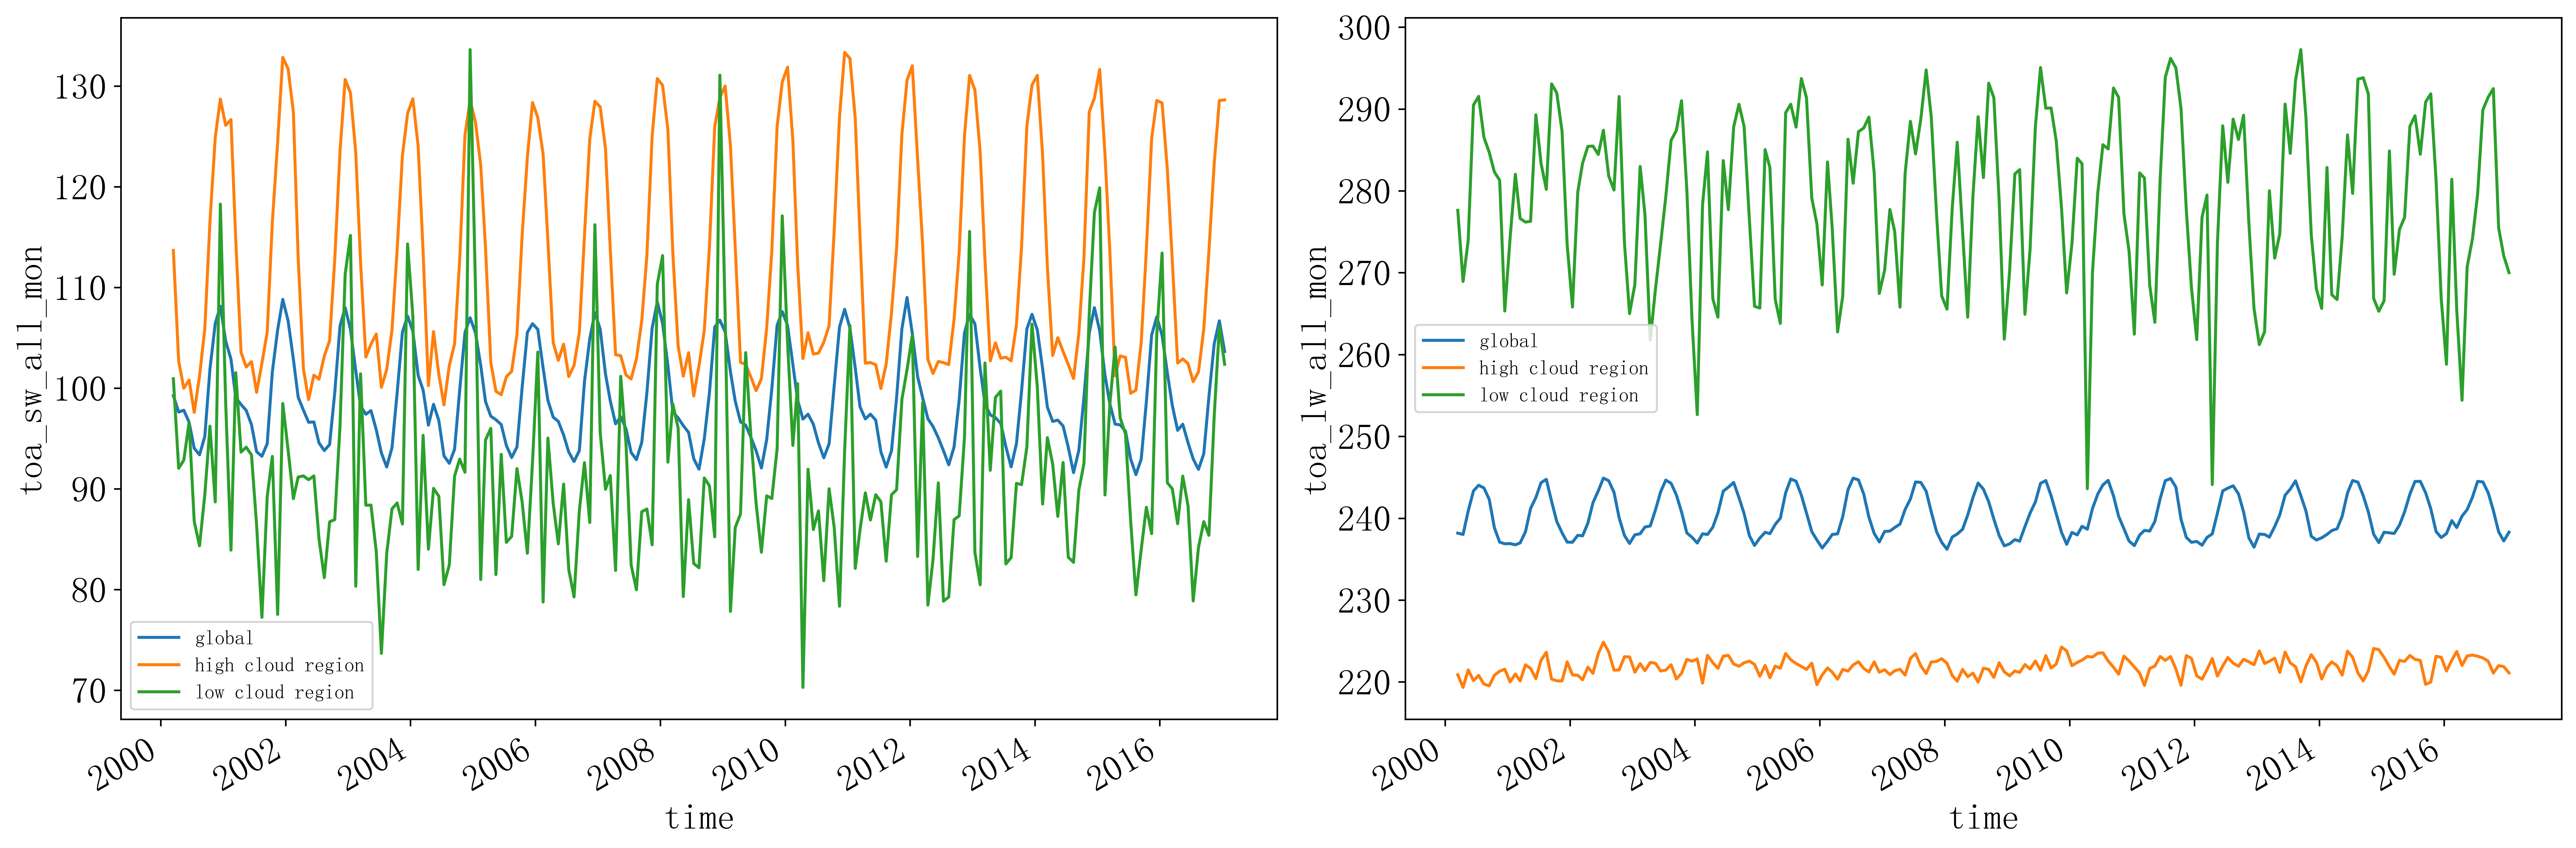

In [51]:
fig = plt.figure(figsize=(18,6), dpi=600)
grid = plt.GridSpec(1, 2)  
plt.subplot(grid[0, 0])
d.toa_sw_all_mon.weighted(weights).mean(dim=['lon','lat']).plot(label='global')
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon>=75)).weighted(weights).mean(dim=['lon','lat']).plot(label='high cloud region')
d.toa_sw_all_mon.where((d.cldarea_total_daynight_mon<=25)).weighted(weights).mean(dim=['lon','lat']).plot(label='low cloud region')
plt.legend(loc='best')
plt.xlabel('time',fontsize=18)
plt.ylabel('toa_sw_all_mon',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.subplot(grid[0, 1])
d.toa_lw_all_mon.weighted(weights).mean(dim=['lon','lat']).plot(label='global')
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon>=75)).weighted(weights).mean(dim=['lon','lat']).plot(label='high cloud region')
d.toa_lw_all_mon.where((d.cldarea_total_daynight_mon<=25)).weighted(weights).mean(dim=['lon','lat']).plot(label='low cloud region')
plt.legend(loc='best')
plt.xlabel('time',fontsize=18)
plt.ylabel('toa_lw_all_mon',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

# 3. Explore a netCDF dataset

### 3.1 Plot a time series of a certain variable with monthly seasonal cycle removed

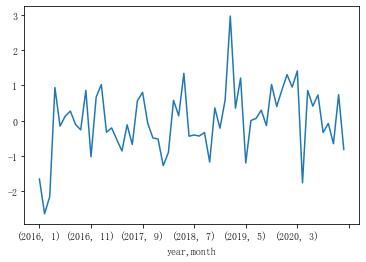

In [52]:
T = xr.open_dataset('2016-2020-T.nc',engine="netcdf4")
T.t2m.mean(dim=('latitude', 'longitude'))

weight = np.cos(np.deg2rad(T.latitude))
T_weighted = T.t2m.weighted(weight)
region_mean = T_weighted.mean(dim=('longitude','latitude'))
a = region_mean.values
index = pd.date_range('2016-01-01', periods=1827, freq='D')
k = 0
t_day = np.zeros(1827)
for i in range(0,1827):
    t_day[i]=a[k:k+24].mean()
    k+=24
tempdf = pd.DataFrame(t_day,columns=['t2m'])
tempdf['date'] = index
tempdf['year'] = pd.DatetimeIndex(tempdf.date).year
tempdf['month'] = pd.DatetimeIndex(tempdf.date).month
t_month = tempdf.groupby(['year','month']).mean()


monthly_T = region_mean.groupby('time.month').mean()
sea = np.zeros(60)
for i in range(0,5):
    sea[12*i:12*i+12] = monthly_T

certain = t_month['t2m'] - sea
certain.plot()

### 3.2 Make at least 5 different plots using the dataset

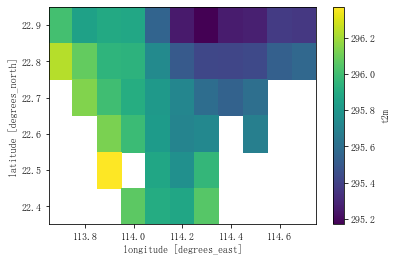

In [54]:
T.t2m.mean(dim='time').plot()

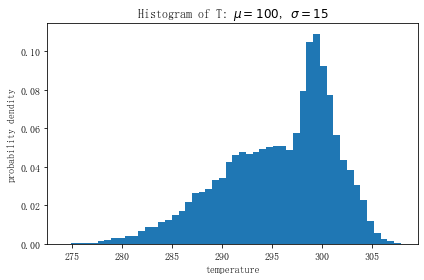

In [55]:
mu = 100 
sigma = 15 
x = region_mean.values
num_bins = 50

fig, ax = plt.subplots()

n, bins, patches = ax.hist(x, num_bins, density=1)

plt.title('Histogram of T: $\mu=100$, $\sigma=15$')
plt.xlabel('temperature')
plt.ylabel('probability dendity')
fig.tight_layout()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x280efe72520>,
 'caps': [<matplotlib.lines.Line2D at 0x280efe72be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x280efe721c0>],
 'medians': [<matplotlib.lines.Line2D at 0x280efe8ba60>],
 'fliers': [<matplotlib.lines.Line2D at 0x280efe8b490>],
 'means': []}

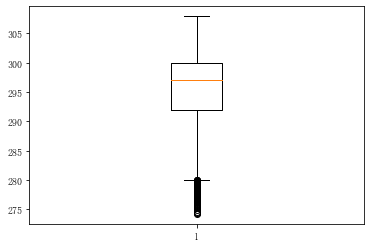

In [56]:
plt.boxplot(region_mean.values)

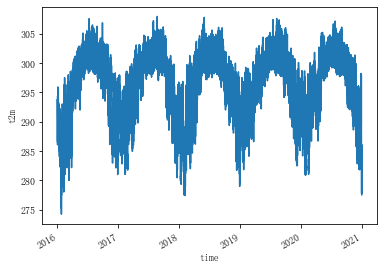

In [57]:
T_weighted.mean(dim=('longitude','latitude')).plot()

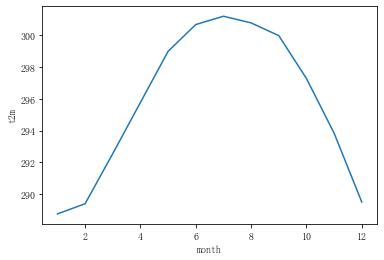

In [58]:
monthly_T.plot()